In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import torch
import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import make_grid
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import time
import cv2
from IPython.display import display
import torch.nn.init as init
from torchsummary import summary

## Note
* There are many training functions and data importing, the reason of this is sometimes syestm restarts or we left the work. So we dont want that our existing result removed. 

In [6]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data directories
data_dir = './input'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Hyperparameters
batch_size = 4
learning_rate = 0.001

# Data preprocessing
stats = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
train_transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(stats[0], stats[1])
])

test_transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
    transforms.Normalize(stats[0], stats[1])
])

# Load data
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
val_data = datasets.ImageFolder(val_dir, transform=test_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Get class names and number of classes
class_names = train_data.classes
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")

Number of classes: 150
Class names: ['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltre

Total number of categories: 150
Total number of images in training dataset: 4716
Total number of images in val dataset: 616
Total number of images in test dataset: 1505


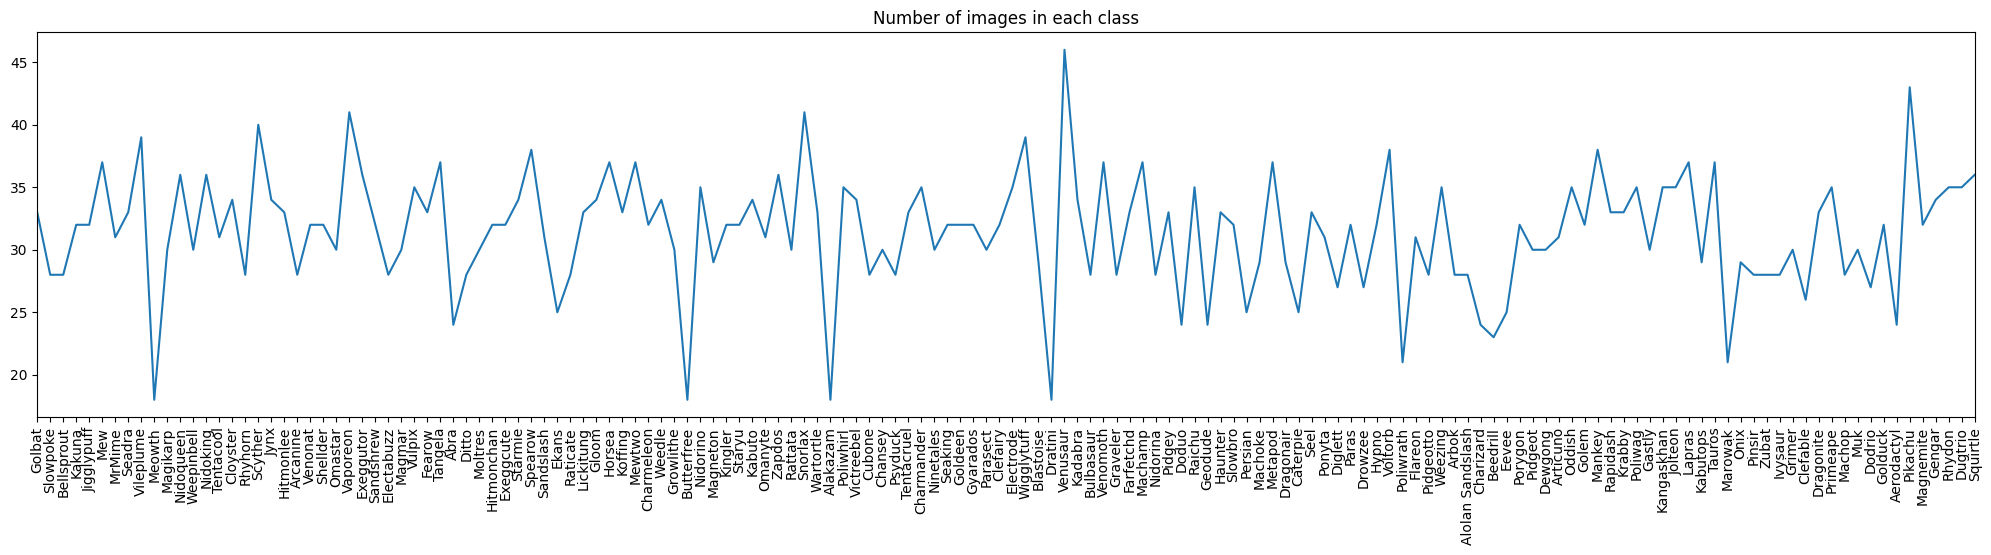

In [32]:
#Check image folder structure
#print(os.listdir(image_dir)[:10])

#Let's check the dataset for each classes

import seaborn as sns

train_dir=data_dir+'/train'
classes = os.listdir(train_dir) # List of all classes
print(f'Total number of categories: {len(classes)}')


counts = {}
counts_val = {}
counts_test = {}
for c in classes:
    counts[c] = len(os.listdir(os.path.join(train_dir, c)))
    counts_test[c] = len(os.listdir(os.path.join(test_dir, c)))
    counts_val[c] = len(os.listdir(os.path.join(val_dir, c)))
print(f'Total number of images in training dataset: {sum(list(counts.values()))}')
print(f'Total number of images in val dataset: {sum(list(counts_val.values()))}')
print(f'Total number of images in test dataset: {sum(list(counts_test.values()))}')
# Number of images in each clsss plot
fig = plt.figure(figsize = (25, 5))
sns.lineplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

In [8]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


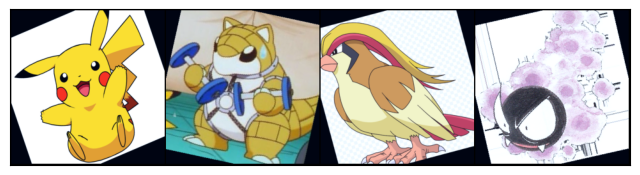

In [5]:
show_batch(train_loader)

In [8]:
# model_0
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
  
    def forward(self, X):
        X = F.relu(self.conv1(X)) # conv1
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X)) # conv2
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X)) # conv3
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#torch.manual_seed(101)
model = ConvolutionalNetwork()
model.to(device)


ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=18816, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=150, bias=True)
)

In [10]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
summary(model, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
            Conv2d-2         [-1, 12, 119, 119]             660
            Conv2d-3           [-1, 24, 57, 57]           2,616
            Linear-4                  [-1, 512]       9,634,304
            Linear-5                  [-1, 256]         131,328
            Linear-6                  [-1, 150]          38,550
Total params: 9,807,626
Trainable params: 9,807,626
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 4.58
Params size (MB): 37.41
Estimated Total Size (MB): 42.67
----------------------------------------------------------------


In [46]:
def train_model(model, epochs, train_loader, val_loader=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train_preds += torch.sum(predicted == target).item()

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train_preds / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        if val_loader:
            model.eval()
            running_val_loss = 0.0
            correct_val_preds = 0

            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)

                    running_val_loss += loss.item() * data.size(0)
                    _, predicted = torch.max(output, 1)
                    correct_val_preds += torch.sum(predicted == target).item()

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val_preds / len(val_loader.dataset)

            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            # print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
            print(f'Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        else:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    return val_losses, val_accuracies

In [10]:
epochs = 10  # Example number of epochs
val_lose, val_accuracy = train_model(model, epochs, train_loader, val_loader)


Epoch [1/10], Val Loss: 4.2855, Val Acc: 0.0423
Epoch [2/10], Val Loss: 3.8730, Val Acc: 0.0813
Epoch [3/10], Val Loss: 3.5032, Val Acc: 0.1415
Epoch [4/10], Val Loss: 3.2768, Val Acc: 0.2033
Epoch [5/10], Val Loss: 3.1662, Val Acc: 0.2260
Epoch [6/10], Val Loss: 3.0847, Val Acc: 0.2211
Epoch [7/10], Val Loss: 3.0630, Val Acc: 0.2439
Epoch [8/10], Val Loss: 2.9054, Val Acc: 0.2764
Epoch [9/10], Val Loss: 2.9855, Val Acc: 0.3024
Epoch [10/10], Val Loss: 2.7780, Val Acc: 0.3626


In [11]:
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_base.pt') 

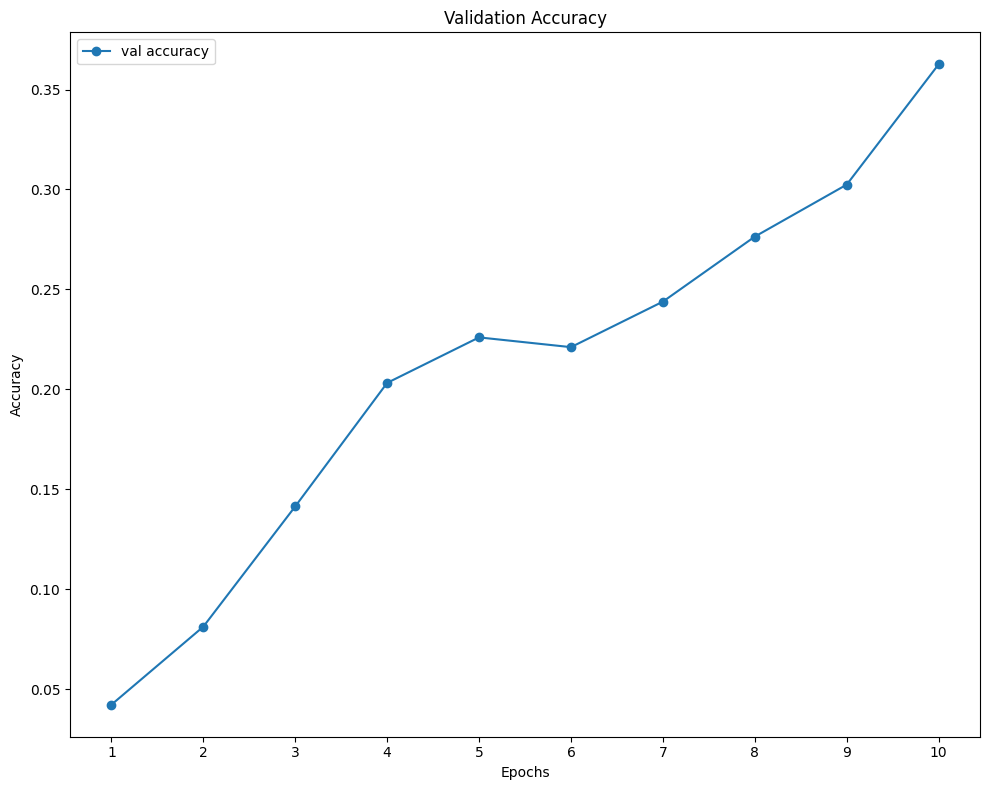

In [12]:
plt.figure(figsize=(10, 8))
plt.plot(range(1, epochs + 1), val_accuracy, label='val accuracy', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Testing the Model 


def test(model, data_loader):
    model.eval()
    test_loss = 0.0
    correct = 0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            predicted = torch.max(outputs, 1)[1]
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            correct += (labels == predicted).sum()
    test_acc=(correct.item()/len(data_loader.dataset))*100
    print(
        f"TEST LOSS: {test_loss / len(data_loader.dataset):.4f}, accuracy: {correct.item() / len(data_loader.dataset):.4f}"
    )

In [48]:
model = ConvolutionalNetwork()
model.load_state_dict(torch.load("./models/model_0_based_models/PokemonModel_base.pt"))
model.to(device)

test(model, test_loader)

TEST LOSS: 0.7232, accuracy: 0.3316


## 1. Several Techniques (2pts)
* Apply Xavier weight initialization, L2 regularization, Dropout, Batch Normalization. 
* Each should start with model_0. 

## 2. Optimization variants (1pts)
Apply SGD, Momentum+SGD,  maybe others optimizers can be tried as well

## 3. Learning rate annealing (1pts)
Apply StepLR, MultistepLR, Exponential LR




## Note

The train function is designed to accept various learning rate schedules and optimizers, allowing us to reduce the amount of code required.

In [30]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

def train(model, epochs, train_loader, val_loader=None, scheduler_type=None, optimizer_type=None, step_size=None, milestones=None, gamma=None):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []



    # optimzer handling with L2 regularization 
    if optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=0.0005, weight_decay=1e-5) #L2 regularization
    elif optimizer_type == 'MomentumSGD':
        optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-5)
    elif optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)  
    elif optimizer_type == 'AdamW':
        optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-5)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")

    # scheduler type handling 
    if scheduler_type == 'StepLR':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == 'MultiStepLR':
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    elif scheduler_type == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    else:
        raise ValueError(f"Unsupported scheduler type: {scheduler_type}")

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train_preds += torch.sum(predicted == target).item()

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train_preds / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        if val_loader:
            model.eval()
            running_val_loss = 0.0
            correct_val_preds = 0

            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)

                    running_val_loss += loss.item() * data.size(0)
                    _, predicted = torch.max(output, 1)
                    correct_val_preds += torch.sum(predicted == target).item()

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val_preds / len(val_loader.dataset)

            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f'Epoch [{epoch + 1}/{epochs}],  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        else:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        scheduler.step()

    return val_losses, val_accuracies


In [11]:
class CNN_1_B(nn.Module):
    def __init__(self, dropout_rate=0.2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.bn2 = nn.BatchNorm2d(12)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.bn3 = nn.BatchNorm2d(24)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(p=dropout_rate)

        # Xavier weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, X):
        X = F.relu(self.bn1(self.conv1(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn2(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.bn3(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)

        X = X.view(-1, 28*28*24)
        # print(X.shape)
        X = self.dropout(F.relu(self.fc1(X)))
        X = self.dropout(F.relu(self.fc2(X)))
        X = self.fc3(X)
        # print(X.shape)
        return X

 Class_1_B is includes important features such as batch normalization, dropout, and appropriate weight initialization to improve performance and training stability.
 i) For feature extraction it has conv layers and batch normalization is between 
 ii) It has fully connected layers for output and a dropout layer to provent overfitting. 
 iii) All  layers use Xavier uniform initialization to ensure that the weights are set appropriately.
 iv) In the forward pass, it Uses max pooling after each ReLU activation to reduce spatial dimensions.
 v) Dropout is applied to improve generalization.

In [12]:
model_1_B = CNN_1_B()
model_1_B.to(device)
summary(model_1_B, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
       BatchNorm2d-2          [-1, 6, 242, 242]              12
            Conv2d-3         [-1, 12, 119, 119]             660
       BatchNorm2d-4         [-1, 12, 119, 119]              24
            Conv2d-5           [-1, 24, 57, 57]           2,616
       BatchNorm2d-6           [-1, 24, 57, 57]              48
            Linear-7                  [-1, 512]       9,634,304
           Dropout-8                  [-1, 512]               0
            Linear-9                  [-1, 256]         131,328
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 150]          38,550
Total params: 9,807,710
Trainable params: 9,807,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forw

In [15]:

epochs = 10  # Example number of epochs
val_lose_1_B, val_accuracy_1_B = train_model(model_1_B, epochs, train_loader, val_loader)


Epoch [1/10], Val Loss: 5.4174, Val Acc: 0.0049
Epoch [2/10], Val Loss: 5.4136, Val Acc: 0.0065
Epoch [3/10], Val Loss: 5.4186, Val Acc: 0.0049
Epoch [4/10], Val Loss: 5.4158, Val Acc: 0.0049
Epoch [5/10], Val Loss: 5.4169, Val Acc: 0.0049
Epoch [6/10], Val Loss: 5.4357, Val Acc: 0.0049
Epoch [7/10], Val Loss: 5.4071, Val Acc: 0.0049
Epoch [8/10], Val Loss: 5.4590, Val Acc: 0.0049
Epoch [9/10], Val Loss: 5.4300, Val Acc: 0.0049
Epoch [10/10], Val Loss: 5.3669, Val Acc: 0.0049


In [16]:
# MultiStep LR and Optimzer is SGD
milestones = [5, 10, 15]
gamma = 0.1
epochs = 10
val_losses_model_1_B_4, val_accuracies_model_1_B_4= train(model_1_B, epochs, train_loader, val_loader,scheduler_type="MultiStepLR", optimizer_type="SGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model_1_B.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B.pt')

Epoch [1/10],  Val Loss: 4.9524, Val Acc: 0.0195
Epoch [2/10],  Val Loss: 4.8335, Val Acc: 0.0276
Epoch [3/10],  Val Loss: 4.7211, Val Acc: 0.0504
Epoch [4/10],  Val Loss: 4.5788, Val Acc: 0.0618
Epoch [5/10],  Val Loss: 4.3986, Val Acc: 0.0797
Epoch [6/10],  Val Loss: 4.3674, Val Acc: 0.0862
Epoch [7/10],  Val Loss: 4.3184, Val Acc: 0.0894
Epoch [8/10],  Val Loss: 4.3168, Val Acc: 0.0992
Epoch [9/10],  Val Loss: 4.2989, Val Acc: 0.0976
Epoch [10/10],  Val Loss: 4.2260, Val Acc: 0.1057


* We have trainned the modified model (model_1_B) in the "for_modified_model.ipynb" file. And that file will be added to the ZIP File.

## Now the given code cells contains the model_0 trained with different LR Schedulers and optimzers ( 12 variantes)

In [24]:
# MultiStep LR and Optimzer is AdamW 

# milestones = [5, 10, 15]
# gamma = 0.1
# epochs = 10
val_losses_model_1_B_2, val_accuracies_model_1_B_2 = train(model, epochs, train_loader, val_loader,scheduler_type="MultiStepLR", optimizer_type="AdamW", step_size=None, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_multiStepLRAW.pt')

Epoch [1/10],  Val Loss: 2.9023, Val Acc: 0.5008
Epoch [2/10],  Val Loss: 2.8897, Val Acc: 0.4894
Epoch [3/10],  Val Loss: 2.9478, Val Acc: 0.5008
Epoch [4/10],  Val Loss: 3.1569, Val Acc: 0.5203
Epoch [5/10],  Val Loss: 3.1459, Val Acc: 0.5024
Epoch [6/10],  Val Loss: 2.9864, Val Acc: 0.5463
Epoch [7/10],  Val Loss: 3.1027, Val Acc: 0.5626
Epoch [8/10],  Val Loss: 3.1953, Val Acc: 0.5707
Epoch [9/10],  Val Loss: 3.4111, Val Acc: 0.5707
Epoch [10/10],  Val Loss: 3.4626, Val Acc: 0.5756


* We train the Model_0 using The MultiStepLR scheduler with milestones at epochs 5, 10, and 15, a gamma of 0.1 was used along with the AdamW optimizer, learning rate of 0.0005 and L2 regularization to train the model across 10 epochs.
* The validation loss shifts, initially falling and then increasing, while the slightly improved but inconsistent validation accuracy indicates probable overfitting.
* The learning rate of 0.0005 may be too low, particularly for the AdamW optimizer, which typically performs better at slightly higher learning rates.

In [25]:
# MultiStep LR and Optimzer is Adam 
val_losses_model_1_B_1, val_accuracies_model_1_B_1 = train(model, epochs, train_loader, val_loader,scheduler_type="MultiStepLR", optimizer_type="Adam", step_size=None, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_multiStepLRA.pt')

Epoch [1/10],  Val Loss: 3.2295, Val Acc: 0.5171
Epoch [2/10],  Val Loss: 3.1336, Val Acc: 0.5236
Epoch [3/10],  Val Loss: 3.1105, Val Acc: 0.4943
Epoch [4/10],  Val Loss: 3.0103, Val Acc: 0.5480
Epoch [5/10],  Val Loss: 3.3366, Val Acc: 0.5366
Epoch [6/10],  Val Loss: 3.1266, Val Acc: 0.5593
Epoch [7/10],  Val Loss: 3.2849, Val Acc: 0.5463
Epoch [8/10],  Val Loss: 3.3501, Val Acc: 0.5480
Epoch [9/10],  Val Loss: 3.5710, Val Acc: 0.5545
Epoch [10/10],  Val Loss: 3.6094, Val Acc: 0.5577


* Here we change the Optimzer to Adam 
* Although fluctuating accuracy indicates some improvement, the increasing val loss points to poor convergence with the Adam optimizer and the current learning rate.

In [26]:
# MultiStep LR and Optimzer is SGD
val_losses_model_1_B_4, val_accuracies_model_1_B_4= train(model, epochs, train_loader, val_loader,scheduler_type="MultiStepLR", optimizer_type="SGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_multiStepLRSGD.pt')

Epoch [1/10],  Val Loss: 3.7851, Val Acc: 0.5577
Epoch [2/10],  Val Loss: 3.8305, Val Acc: 0.5545
Epoch [3/10],  Val Loss: 3.9236, Val Acc: 0.5626
Epoch [4/10],  Val Loss: 3.9045, Val Acc: 0.5463
Epoch [5/10],  Val Loss: 4.0721, Val Acc: 0.5528
Epoch [6/10],  Val Loss: 4.0504, Val Acc: 0.5593
Epoch [7/10],  Val Loss: 4.0277, Val Acc: 0.5512
Epoch [8/10],  Val Loss: 3.9967, Val Acc: 0.5463
Epoch [9/10],  Val Loss: 4.0137, Val Acc: 0.5431
Epoch [10/10],  Val Loss: 4.0259, Val Acc: 0.5463


* Now we trainned our Model with SGD Optimizer
* Validation loss fluctuates but remains steady overall, showing consistent model performance, while validation accuracy improves gradually across epochs, illustrating effective learning.
* But this shows slow convergence


In [15]:
# MultiStep LR and Optimzer is MomentumSGD 
epochs = 10
milestones = [5, 10, 15]
gamma = 0.1
val_losses_model_1_B_3, val_accuracies_model_1_B_3= train(model, epochs, train_loader, val_loader,scheduler_type="MultiStepLR", optimizer_type="MomentumSGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_multiStepLRMSGD.pt')

Epoch [1/10],  Val Loss: 4.8671, Val Acc: 0.0195
Epoch [2/10],  Val Loss: 4.2374, Val Acc: 0.0520
Epoch [3/10],  Val Loss: 3.8430, Val Acc: 0.0976
Epoch [4/10],  Val Loss: 3.5878, Val Acc: 0.1659
Epoch [5/10],  Val Loss: 3.3231, Val Acc: 0.2049
Epoch [6/10],  Val Loss: 2.9724, Val Acc: 0.2976
Epoch [7/10],  Val Loss: 2.8888, Val Acc: 0.3122
Epoch [8/10],  Val Loss: 2.8660, Val Acc: 0.3122
Epoch [9/10],  Val Loss: 2.8268, Val Acc: 0.3317
Epoch [10/10],  Val Loss: 2.7965, Val Acc: 0.3350


* Training with the MomentumSGD optimizer and MultiStepLR scheduler produced results with a very low validation accuracy and static validation loss over the course of epochs, indicating poor model performance and ineffective learning.

In [16]:
# StepLR and Optimzer is AdamW 

val_losses_model_1_B_SLR_adamW, val_accuracies_model_1_B_SLR_adamW = train(model, epochs, train_loader, val_loader,scheduler_type="StepLR", optimizer_type="AdamW", step_size=5, milestones = None, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_StepLRAW.pt')

Epoch [1/10],  Val Loss: 2.9866, Val Acc: 0.2553
Epoch [2/10],  Val Loss: 2.7026, Val Acc: 0.3317
Epoch [3/10],  Val Loss: 2.4726, Val Acc: 0.3789
Epoch [4/10],  Val Loss: 2.2972, Val Acc: 0.4195
Epoch [5/10],  Val Loss: 2.2622, Val Acc: 0.4390
Epoch [6/10],  Val Loss: 2.1565, Val Acc: 0.5041
Epoch [7/10],  Val Loss: 2.1848, Val Acc: 0.5187
Epoch [8/10],  Val Loss: 2.2148, Val Acc: 0.5285
Epoch [9/10],  Val Loss: 2.2585, Val Acc: 0.5236
Epoch [10/10],  Val Loss: 2.3263, Val Acc: 0.5415


In [17]:
# StepLR and Optimzer is Adam 

val_losses_model_1_B_SLR_adam, val_accuracies_model_1_B_SLR_adam = train(model, epochs, train_loader, val_loader,scheduler_type="StepLR", optimizer_type="Adam", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_StepLRA.pt')

Epoch [1/10],  Val Loss: 2.3338, Val Acc: 0.4732
Epoch [2/10],  Val Loss: 2.3718, Val Acc: 0.4764
Epoch [3/10],  Val Loss: 2.4352, Val Acc: 0.4862
Epoch [4/10],  Val Loss: 2.5202, Val Acc: 0.4797
Epoch [5/10],  Val Loss: 2.6129, Val Acc: 0.4862
Epoch [6/10],  Val Loss: 2.4444, Val Acc: 0.5382
Epoch [7/10],  Val Loss: 2.5992, Val Acc: 0.5528
Epoch [8/10],  Val Loss: 2.6869, Val Acc: 0.5740
Epoch [9/10],  Val Loss: 2.8932, Val Acc: 0.5528
Epoch [10/10],  Val Loss: 3.0347, Val Acc: 0.5545


In [18]:
# StepLR and Optimzer is SGD 
val_losses_model_1_B_SLR_SGD, val_accuracies_model_1_B_SLR_SGD= train(model, epochs, train_loader, val_loader,scheduler_type="StepLR", optimizer_type="SGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_StepLRSGD.pt')

Epoch [1/10],  Val Loss: 3.1644, Val Acc: 0.5610
Epoch [2/10],  Val Loss: 3.2781, Val Acc: 0.5707
Epoch [3/10],  Val Loss: 3.2527, Val Acc: 0.5756
Epoch [4/10],  Val Loss: 3.3870, Val Acc: 0.5561
Epoch [5/10],  Val Loss: 3.4183, Val Acc: 0.5577
Epoch [6/10],  Val Loss: 3.4685, Val Acc: 0.5642
Epoch [7/10],  Val Loss: 3.4921, Val Acc: 0.5626
Epoch [8/10],  Val Loss: 3.5126, Val Acc: 0.5610
Epoch [9/10],  Val Loss: 3.5455, Val Acc: 0.5626
Epoch [10/10],  Val Loss: 3.5649, Val Acc: 0.5659


In [19]:
# StepLR and Optimzer is MomentumSGD 
val_losses_model_1_B_SLR_MSGD, val_accuracies_model_1_B_SLR_MSGD= train(model, epochs, train_loader, val_loader,scheduler_type="StepLR", optimizer_type="MomentumSGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_StepLRMSGD.pt')

Epoch [1/10],  Val Loss: 3.4390, Val Acc: 0.3984
Epoch [2/10],  Val Loss: 2.7768, Val Acc: 0.4488
Epoch [3/10],  Val Loss: 3.1258, Val Acc: 0.4472
Epoch [4/10],  Val Loss: 2.9267, Val Acc: 0.4553
Epoch [5/10],  Val Loss: 3.7318, Val Acc: 0.4374
Epoch [6/10],  Val Loss: 2.8469, Val Acc: 0.5366
Epoch [7/10],  Val Loss: 2.9950, Val Acc: 0.5236
Epoch [8/10],  Val Loss: 3.0722, Val Acc: 0.5317
Epoch [9/10],  Val Loss: 3.2172, Val Acc: 0.5398
Epoch [10/10],  Val Loss: 3.2990, Val Acc: 0.5398


In [29]:
# ExponentialLR and Optimzer is AdamW 

val_losses_model_1_B_ESLR_adam, val_accuracies_model_1_B_ESLR_adam = train(model, epochs, train_loader, val_loader,scheduler_type="ExponentialLR", optimizer_type="Adam", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_ELRA.pt')

Epoch [1/10],  Val Loss: 3.3234, Val Acc: 0.5366
Epoch [2/10],  Val Loss: 3.0633, Val Acc: 0.5610
Epoch [3/10],  Val Loss: 3.0781, Val Acc: 0.5659
Epoch [4/10],  Val Loss: 3.0784, Val Acc: 0.5675
Epoch [5/10],  Val Loss: 3.0786, Val Acc: 0.5691
Epoch [6/10],  Val Loss: 3.0786, Val Acc: 0.5691
Epoch [7/10],  Val Loss: 3.0786, Val Acc: 0.5691
Epoch [8/10],  Val Loss: 3.0786, Val Acc: 0.5691
Epoch [9/10],  Val Loss: 3.0786, Val Acc: 0.5691
Epoch [10/10],  Val Loss: 3.0786, Val Acc: 0.5691


In [20]:
# ExponentialLR and Optimzer is Adam
# milestones = [5, 10, 15]
# gamma = 0.1
# epochs = 10
val_losses_model_1_B_ESLR_adamW, val_accuracies_model_1_B_ESLR_adamW = train(model, epochs, train_loader, val_loader,scheduler_type="ExponentialLR", optimizer_type="AdamW", step_size=5, milestones = None, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_ELRAW.pt')

Epoch [1/10],  Val Loss: 2.8310, Val Acc: 0.5041
Epoch [2/10],  Val Loss: 2.7656, Val Acc: 0.5317
Epoch [3/10],  Val Loss: 2.7727, Val Acc: 0.5301
Epoch [4/10],  Val Loss: 2.7735, Val Acc: 0.5301
Epoch [5/10],  Val Loss: 2.7737, Val Acc: 0.5301
Epoch [6/10],  Val Loss: 2.7737, Val Acc: 0.5301
Epoch [7/10],  Val Loss: 2.7737, Val Acc: 0.5301
Epoch [8/10],  Val Loss: 2.7737, Val Acc: 0.5301
Epoch [9/10],  Val Loss: 2.7737, Val Acc: 0.5301
Epoch [10/10],  Val Loss: 2.7737, Val Acc: 0.5301


In [21]:
# ExponentialLR and Optimzer is SGD 

val_losses_model_1_B_ESLR_SGD, val_accuracies_model_1_B_ESLR_SGD= train(model, epochs, train_loader, val_loader,scheduler_type="ExponentialLR", optimizer_type="SGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_ELRSGD.pt')

Epoch [1/10],  Val Loss: 3.0076, Val Acc: 0.5317
Epoch [2/10],  Val Loss: 3.0477, Val Acc: 0.5333
Epoch [3/10],  Val Loss: 3.0492, Val Acc: 0.5350
Epoch [4/10],  Val Loss: 3.0493, Val Acc: 0.5350
Epoch [5/10],  Val Loss: 3.0493, Val Acc: 0.5350
Epoch [6/10],  Val Loss: 3.0493, Val Acc: 0.5350
Epoch [7/10],  Val Loss: 3.0493, Val Acc: 0.5350
Epoch [8/10],  Val Loss: 3.0493, Val Acc: 0.5350
Epoch [9/10],  Val Loss: 3.0493, Val Acc: 0.5350
Epoch [10/10],  Val Loss: 3.0493, Val Acc: 0.5350


In [22]:
# ExponentialLR and Optimzer is MomentumSGD 

val_losses_model_1_B_SLR_EMSGD, val_accuracies_model_1_B_ESLR_MSGD= train(model, epochs, train_loader, val_loader,scheduler_type="ExponentialLR", optimizer_type="MomentumSGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model.state_dict(), './models/model_0_based_models/PokemonModel_model_1_B_ELRMSGD.pt')

Epoch [1/10],  Val Loss: 3.2785, Val Acc: 0.4764
Epoch [2/10],  Val Loss: 3.0617, Val Acc: 0.5252
Epoch [3/10],  Val Loss: 3.0124, Val Acc: 0.5252
Epoch [4/10],  Val Loss: 3.0131, Val Acc: 0.5220
Epoch [5/10],  Val Loss: 3.0130, Val Acc: 0.5220
Epoch [6/10],  Val Loss: 3.0130, Val Acc: 0.5220
Epoch [7/10],  Val Loss: 3.0130, Val Acc: 0.5220
Epoch [8/10],  Val Loss: 3.0130, Val Acc: 0.5220
Epoch [9/10],  Val Loss: 3.0130, Val Acc: 0.5220
Epoch [10/10],  Val Loss: 3.0130, Val Acc: 0.5220


Model 1_4 MultiStepLR and the optimzers are (AdamW -> Adam -> SGD -> Momentum+SGD)
Model 5_8 StepLR and the optimzers are (AdamW -> Adam -> SGD -> Momentum+SGD)
Model 9_12 ExponentialLR and the optimzers are (Adam -> AdamW -> SGD -> Momentum+SGD)


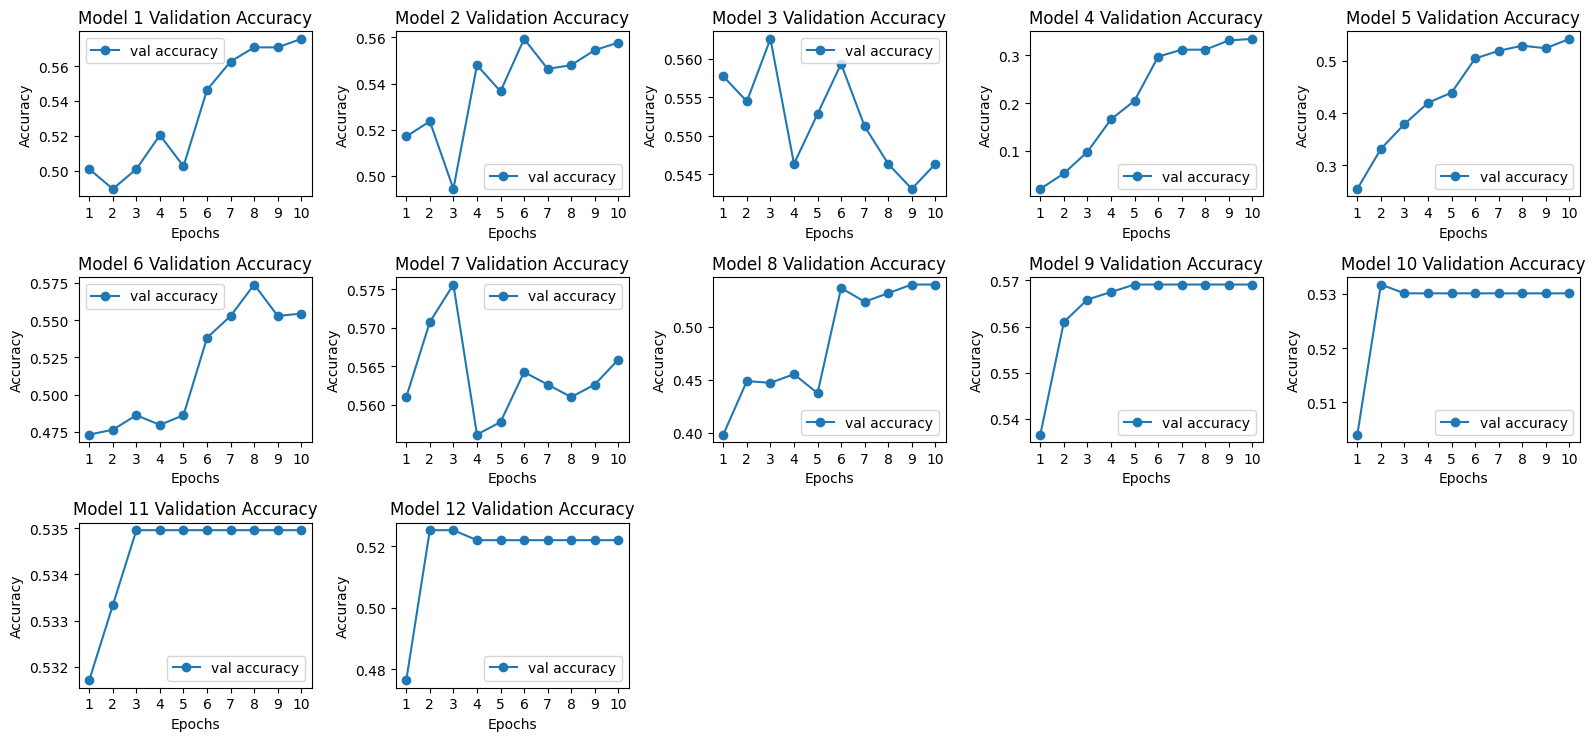

In [45]:
val_accuracies = [
   val_accuracies_model_1_B_2,
 val_accuracies_model_1_B_1,
 val_accuracies_model_1_B_4,
 val_accuracies_model_1_B_3,
 val_accuracies_model_1_B_SLR_adamW,
 val_accuracies_model_1_B_SLR_adam,
 val_accuracies_model_1_B_SLR_SGD,
 val_accuracies_model_1_B_SLR_MSGD,
val_accuracies_model_1_B_ESLR_adam,
 val_accuracies_model_1_B_ESLR_adamW,
val_accuracies_model_1_B_ESLR_SGD,
 val_accuracies_model_1_B_ESLR_MSGD,
]


print("Model 1_4 MultiStepLR and the optimzers are (AdamW -> Adam -> SGD -> Momentum+SGD)")
print("Model 5_8 StepLR and the optimzers are (AdamW -> Adam -> SGD -> Momentum+SGD)")
print("Model 9_12 ExponentialLR and the optimzers are (Adam -> AdamW -> SGD -> Momentum+SGD)")

# Plotting all 12 validation accuracy results
plt.figure(figsize=(16, 12))  

for i, val_accuracy in enumerate(val_accuracies, 1):
    plt.subplot(5, 5, i)
    plt.plot(range(1, epochs + 1), val_accuracy, label='val accuracy', marker='o')
    plt.title(f'Model {i} Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, epochs + 1))
    plt.legend()

plt.tight_layout()
plt.show()


## 4. Dilated Conv (1pts)
we can use dilated 3x3 conv to enlarge the receptive field. So this time, let's try dialted 3x3 conv to see what difference it makes.

In [13]:
class Dilated_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1, padding=1, dilation=2)
        self.conv2 = nn.Conv2d(6, 12, 3, 1, padding=1, dilation=2)
        self.conv3 = nn.Conv2d(12, 24, 3, 1, padding=1, dilation=2)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
  
    def forward(self, X):
        X = F.relu(self.conv1(X))  # conv1 with dilation
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))  # conv2 with dilation
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))  # conv3 with dilation
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X



* The convolutions conv1, conv2, and conv3 in this modified model utilizes a dilation rate of 2 and padding = 1. 
* By doing this, the model is able to extract additional context from the input images by expanding the receptive field of each convolution without increasing the kernel size.

In [35]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [15]:
model_D = Dilated_CNN()
model_D.to(device)
summary(model_D, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
            Conv2d-2         [-1, 12, 119, 119]             660
            Conv2d-3           [-1, 24, 57, 57]           2,616
            Linear-4                  [-1, 512]       9,634,304
            Linear-5                  [-1, 256]         131,328
            Linear-6                  [-1, 150]          38,550
Total params: 9,807,626
Trainable params: 9,807,626
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 4.58
Params size (MB): 37.41
Estimated Total Size (MB): 42.67
----------------------------------------------------------------


In [37]:
# model_D = Dilated_CNN()
# model_D.to(device)
milestones = [5, 10, 15]
gamma = 0.1
epochs = 10  # Example number of epochs
val_lose_di, val_accuracy_di = train(model_D, epochs, train_loader, val_loader,scheduler_type="StepLR", optimizer_type="SGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model_D.state_dict(), './models/model_0_based_models/PokemonModel_base_dialated.pt') 

Epoch [1/10],  Val Loss: 5.0085, Val Acc: 0.0114
Epoch [2/10],  Val Loss: 5.0060, Val Acc: 0.0163
Epoch [3/10],  Val Loss: 5.0039, Val Acc: 0.0195
Epoch [4/10],  Val Loss: 5.0009, Val Acc: 0.0146
Epoch [5/10],  Val Loss: 4.9973, Val Acc: 0.0114
Epoch [6/10],  Val Loss: 4.9965, Val Acc: 0.0130
Epoch [7/10],  Val Loss: 4.9958, Val Acc: 0.0146
Epoch [8/10],  Val Loss: 4.9951, Val Acc: 0.0146
Epoch [9/10],  Val Loss: 4.9944, Val Acc: 0.0146
Epoch [10/10],  Val Loss: 4.9938, Val Acc: 0.0146


We trainned the model with different LR and Optimzer but there is not significant improment in th val accuracy.

## 5. 1x1 Conv (2pts)

As we learned in the class 1x1 conv can be utilized to reduce the computation. To see the computation reduction, lets first change one or more of the three 3x3 convs to be 7x7 (you may have to adjust other layers as well in order to the NN work). Then apply 1x1 technique to make it faster

In [16]:
class Modified_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 7, 1, padding = 2)
        self.conv_2_1x1 = nn.Conv2d(12, 6, 1, 1)
        self.conv3 = nn.Conv2d(6, 24, 7, 1, padding=2)
        self.conv_3_1x1 = nn.Conv2d(24, 6, 1, 1)
        self.fc1 = nn.Linear(6 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv_2_1x1(self.conv2(X)))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv_3_1x1(self.conv3(X)))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(X.size(0), -1)  # Flatten the tensor
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X


* In CNNs, the 1x1 convolution is an effective tool that can be used for a variety of tasks, such as dimensionality reduction, feature extraction, and deepening the model without increasing computational complexity.

In [17]:
model_M = Modified_CNN()
model_M.to(device)
summary(model_M, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
            Conv2d-2         [-1, 12, 119, 119]           3,540
            Conv2d-3          [-1, 6, 119, 119]              78
            Conv2d-4           [-1, 24, 57, 57]           7,080
            Conv2d-5            [-1, 6, 57, 57]             150
            Linear-6                  [-1, 512]       2,408,960
            Linear-7                  [-1, 256]         131,328
            Linear-8                  [-1, 150]          38,550
Total params: 2,589,854
Trainable params: 2,589,854
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 5.38
Params size (MB): 9.88
Estimated Total Size (MB): 15.94
----------------------------------------------------------------


In [40]:
# model_M = Modified_CNN()
# model_M.to(device)
epochs = 10 
val_lose_d, val_accuracy_d = train(model_D, epochs, train_loader, val_loader,scheduler_type="StepLR", optimizer_type="SGD", 
                                                           step_size=5, milestones = milestones, gamma= gamma)
torch.save(model_M.state_dict(), './models/model_0_based_models/PokemonModel_base_1x1.pt') 

Epoch [1/10],  Val Loss: 4.9884, Val Acc: 0.0195
Epoch [2/10],  Val Loss: 4.9789, Val Acc: 0.0163
Epoch [3/10],  Val Loss: 4.9626, Val Acc: 0.0179
Epoch [4/10],  Val Loss: 4.9333, Val Acc: 0.0179
Epoch [5/10],  Val Loss: 4.8952, Val Acc: 0.0211
Epoch [6/10],  Val Loss: 4.8676, Val Acc: 0.0276
Epoch [7/10],  Val Loss: 4.8541, Val Acc: 0.0325
Epoch [8/10],  Val Loss: 4.8426, Val Acc: 0.0309
Epoch [9/10],  Val Loss: 4.8344, Val Acc: 0.0309
Epoch [10/10],  Val Loss: 4.8222, Val Acc: 0.0309


We trained the model with different LR and Optimzer however the model appears to train extremely slowly, as illustrated by the gradual decrease in validation loss and minor rise in validation accuracy over epoch.

## 6. Instable NN (1pts)
Let's modify the model so that the model has softmax output inside the model and then apply log and NLLLoss to test whether it really has numerical instability

In [18]:
class Instable_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
  
    def forward(self, X):
        X = F.relu(self.conv1(X))  # conv1
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))  # conv2
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))  # conv3
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 28*28*24)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        X = F.softmax(X, dim=1)  
        return X

In [28]:
def train_instable(model, epochs, train_loader, val_loader):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.NLLLoss()  # Using NLLLoss

    for epoch in range(epochs):
        model.train()
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            log_output = torch.log(output)  # Apply log to the output
            loss = criterion(log_output, target)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                log_output = torch.log(output)  
                val_loss += criterion(log_output, target).item()
                pred = log_output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print(f'Epoch: {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    return val_loss, val_accuracy


In [19]:
model_Instable = Instable_CNN()
model_Instable.to(device)
summary(model_Instable, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
            Conv2d-2         [-1, 12, 119, 119]             660
            Conv2d-3           [-1, 24, 57, 57]           2,616
            Linear-4                  [-1, 512]       9,634,304
            Linear-5                  [-1, 256]         131,328
            Linear-6                  [-1, 150]          38,550
Total params: 9,807,626
Trainable params: 9,807,626
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 4.58
Params size (MB): 37.41
Estimated Total Size (MB): 42.67
----------------------------------------------------------------


In [29]:

epochs = 10 
val_lose_in, val_accuracy_in = train_instable(model_Instable, epochs, train_loader, val_loader)
torch.save(model_Instable.state_dict(), './models/model_0_based_models/PokemonModel_base_instable.pt') 

Epoch: 1, Validation Loss: 1.0809, Validation Accuracy: 6.5041
Epoch: 2, Validation Loss: 0.9197, Validation Accuracy: 10.8943
Epoch: 3, Validation Loss: 0.8684, Validation Accuracy: 15.4472
Epoch: 4, Validation Loss: 0.7946, Validation Accuracy: 23.7398
Epoch: 5, Validation Loss: nan, Validation Accuracy: 0.4878
Epoch: 6, Validation Loss: nan, Validation Accuracy: 0.4878
Epoch: 7, Validation Loss: nan, Validation Accuracy: 0.4878
Epoch: 8, Validation Loss: nan, Validation Accuracy: 0.4878
Epoch: 9, Validation Loss: nan, Validation Accuracy: 0.4878
Epoch: 10, Validation Loss: nan, Validation Accuracy: 0.4878


After adding Softmax in the forward block and usinng NLLLOSS() -> the reason for these results is that when probabilities produced by F.softmax approach zero, applying the logarithm to those probabilities may result in numerical instability, which could provide NaN values in the loss calculation.

In [31]:
print("Validation Loss:", val_lose_in)
print("Validation Accuracy:", val_accuracy_in)

Validation Loss: nan
Validation Accuracy: 0.4878048780487805


## 7. variable sized input (2pts)
The current model requires the input to be of 240x240 or more precisely 238x238 (both work with current model). Let's make the model takes any size input by using adaptive pooling. You may need to remove one or more pooling layers to make the minimum input size (you need to calculate this considering the operations in your model) less smaller than 240(or 238) so that you don't need to resize many of the images to make it bigger to fit the minimum input size. Still there maybe some images smaller than the minimum size, in that case you may have to reisze the image to the minimum size. 

In [20]:
class Adaptive_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.fc1 = nn.Linear(24 * 26 * 26, 512)  
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X)) 
        X = F.adaptive_max_pool2d(X, (118, 118))  
        X = F.relu(self.conv2(X))  
        X = F.adaptive_max_pool2d(X, (57, 57))  
        X = F.relu(self.conv3(X)) 
        X = F.adaptive_max_pool2d(X, (26, 26)) 
        X = X.view(-1, 24 * 26 * 26)  
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [13]:
def train_ad(model, epochs, train_loader, val_loader=None):
    criterion = nn.CrossEntropyLoss().to(device)  # loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # optimizer

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train_preds += torch.sum(predicted == target).item()

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train_preds / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        if val_loader:
            model.eval()
            running_val_loss = 0.0
            correct_val_preds = 0

            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)

                    running_val_loss += loss.item() * data.size(0)
                    _, predicted = torch.max(output, 1)
                    correct_val_preds += torch.sum(predicted == target).item()

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val_preds / len(val_loader.dataset)

            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f'Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        else:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    return val_losses, val_accuracies

In [22]:
model_Adap = Adaptive_CNN()
model_Adap.to(device)
summary(model_Adap, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
            Conv2d-2         [-1, 12, 116, 116]             660
            Conv2d-3           [-1, 24, 55, 55]           2,616
            Linear-4                  [-1, 512]       8,307,200
            Linear-5                  [-1, 256]         131,328
            Linear-6                  [-1, 150]          38,550
Total params: 8,480,522
Trainable params: 8,480,522
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 4.47
Params size (MB): 32.35
Estimated Total Size (MB): 37.51
----------------------------------------------------------------


In [14]:

epochs = 10 
val_lose_ad, val_accuracy_ad = train_ad(model_Adap, epochs, train_loader, val_loader)
torch.save(model_Adap.state_dict(), './models/model_0_based_models/PokemonModel_base_Adap.pt') 

Epoch [1/10], Val Loss: 4.0306, Val Acc: 0.0634
Epoch [2/10], Val Loss: 3.5442, Val Acc: 0.1431
Epoch [3/10], Val Loss: 3.1955, Val Acc: 0.2130
Epoch [4/10], Val Loss: 2.8921, Val Acc: 0.2683
Epoch [5/10], Val Loss: 2.7876, Val Acc: 0.3057
Epoch [6/10], Val Loss: 2.7258, Val Acc: 0.3398
Epoch [7/10], Val Loss: 2.4699, Val Acc: 0.3805
Epoch [8/10], Val Loss: 2.4564, Val Acc: 0.4081
Epoch [9/10], Val Loss: 2.4174, Val Acc: 0.4228
Epoch [10/10], Val Loss: 2.3435, Val Acc: 0.4325


The Adaptive_CNN model uses adaptive pooling to retain spatial resolution flexibility across the network, catching finer features in shifting input sizes. The validation accuracy is likewise increasing, indicating that the model is improving its ability to accurately categorize the validation dataset

## 8. Upsampling by transposed conv (2pts)

the model so far will look like (a) below. In order to get familiar with upsampling. Let's just apply the transposed conv here so that the model looks like (b).

<img src="./fig/img1.jpg" width="500">

In [23]:


class Transposed_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        self.transposed_conv = nn.ConvTranspose2d(24, 12, 2, stride=2)
        self.fc1 = nn.Linear(28*28*48, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, X):
        X = F.relu(self.conv1(X))  # conv1
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))  # conv2
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv3(X))  # conv3
        X = F.max_pool2d(X, 2, 2)
        X = self.transposed_conv(X)  # Transposed conv (upsampling)
        X = X.view(-1, 28*28*48)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return X

In [16]:
def train_tr(model, epochs, train_loader, val_loader=None):
    criterion = nn.CrossEntropyLoss().to(device)  # loss function
    optimizer = optim.Adam(model.parameters(), lr=0.001)  # optimizer

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_train_loss = 0.0
        correct_train_preds = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_train_preds += torch.sum(predicted == target).item()

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train_preds / len(train_loader.dataset)

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        if val_loader:
            model.eval()
            running_val_loss = 0.0
            correct_val_preds = 0

            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)

                    running_val_loss += loss.item() * data.size(0)
                    _, predicted = torch.max(output, 1)
                    correct_val_preds += torch.sum(predicted == target).item()

            val_loss = running_val_loss / len(val_loader.dataset)
            val_acc = correct_val_preds / len(val_loader.dataset)

            val_losses.append(val_loss)
            val_accuracies.append(val_acc)

            print(f'Epoch [{epoch + 1}/{epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        else:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

    return val_losses, val_accuracies

In [25]:
model_trans = Transposed_CNN()
model_trans.to(device)
summary(model_trans, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
            Conv2d-2         [-1, 12, 119, 119]             660
            Conv2d-3           [-1, 24, 57, 57]           2,616
   ConvTranspose2d-4           [-1, 12, 56, 56]           1,164
            Linear-5                  [-1, 512]      19,268,096
            Linear-6                  [-1, 256]         131,328
            Linear-7                  [-1, 150]          38,550
Total params: 19,442,582
Trainable params: 19,442,582
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 4.87
Params size (MB): 74.17
Estimated Total Size (MB): 79.72
----------------------------------------------------------------


In [17]:

epochs = 10
val_lose_tr, val_accuracy_tr = train_tr(model_trans, epochs, train_loader, val_loader)
torch.save(model_trans.state_dict(), './models/model_0_based_models/PokemonModel_base_tr.pt') 

Epoch [1/10], Val Loss: 4.3878, Val Acc: 0.0244
Epoch [2/10], Val Loss: 3.9476, Val Acc: 0.0813
Epoch [3/10], Val Loss: 3.8207, Val Acc: 0.1089
Epoch [4/10], Val Loss: 3.5060, Val Acc: 0.1561
Epoch [5/10], Val Loss: 3.3043, Val Acc: 0.1919
Epoch [6/10], Val Loss: 3.2316, Val Acc: 0.2130
Epoch [7/10], Val Loss: 3.1029, Val Acc: 0.2504
Epoch [8/10], Val Loss: 3.0300, Val Acc: 0.2585
Epoch [9/10], Val Loss: 3.0153, Val Acc: 0.2699
Epoch [10/10], Val Loss: 3.0935, Val Acc: 0.3024


Due transposed conv layer's up_sampling impact, the fully connected layers in Transposed_CNN receive more input data and able to capture more detailed spatial information. The results demonstrate a clear improvement in both validation loss and accuracy over the 10 epochs.

## 9. Two branch network (3pts)

Let's make a two-branch model, which looks like below.

<img src="./fig/img2.jpg" width="500">

In [26]:
class Two_Branch_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Convolutional branch
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 12, 3, 1)
        self.conv3 = nn.Conv2d(12, 24, 3, 1)
        
        # Fully connected branch
        self.fc1 = nn.Linear(28*28*24, 512)
        self.fc2 = nn.Linear(512, 256)
        
        # Combined branch
        self.fc3 = nn.Linear(28*28*24 + 256, num_classes)
  
    def forward(self, X):
        # Convolutional branch
        X_conv = F.relu(self.conv1(X))
        X_conv = F.max_pool2d(X_conv, 2, 2)
        X_conv = F.relu(self.conv2(X_conv))
        X_conv = F.max_pool2d(X_conv, 2, 2)
        X_conv = F.relu(self.conv3(X_conv))
        X_conv = F.max_pool2d(X_conv, 2, 2)
        X_conv = X_conv.view(-1, 28*28*24)
        
        # Fully connected branch
        X_fc = F.relu(self.fc1(X_conv))
        X_fc = F.relu(self.fc2(X_fc))
        
        # Combine the outputs of the two branches
        X = torch.cat((X_conv, X_fc), dim=1)
        X = self.fc3(X)
        
        return X

In [27]:
model_br = Two_Branch_CNN()
model_br.to(device)
summary(model_br, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 242, 242]             168
            Conv2d-2         [-1, 12, 119, 119]             660
            Conv2d-3           [-1, 24, 57, 57]           2,616
            Linear-4                  [-1, 512]       9,634,304
            Linear-5                  [-1, 256]         131,328
            Linear-6                  [-1, 150]       2,860,950
Total params: 12,630,026
Trainable params: 12,630,026
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.68
Forward/backward pass size (MB): 4.58
Params size (MB): 48.18
Estimated Total Size (MB): 53.44
----------------------------------------------------------------


In [19]:

epochs = 10
val_lose_br, val_accuracy_br = train_tr(model_br, epochs, train_loader, val_loader)
torch.save(model_br.state_dict(), './models/model_0_based_models/PokemonModel_base_br.pt') 

Epoch [1/10], Val Loss: 4.4592, Val Acc: 0.0455
Epoch [2/10], Val Loss: 4.1812, Val Acc: 0.1138
Epoch [3/10], Val Loss: 3.8771, Val Acc: 0.1528
Epoch [4/10], Val Loss: 3.5646, Val Acc: 0.2341
Epoch [5/10], Val Loss: 3.4153, Val Acc: 0.2780
Epoch [6/10], Val Loss: 3.1408, Val Acc: 0.3187
Epoch [7/10], Val Loss: 2.9728, Val Acc: 0.3626
Epoch [8/10], Val Loss: 2.9065, Val Acc: 0.3772
Epoch [9/10], Val Loss: 2.9789, Val Acc: 0.3854
Epoch [10/10], Val Loss: 3.0019, Val Acc: 0.4000


Here we process input data through two separate branches before integrating the results, which enables the model to extract and integrate different features from the input data. The results demonstrate a clear improvement in both validation loss and accuracy over the 10 epochs.

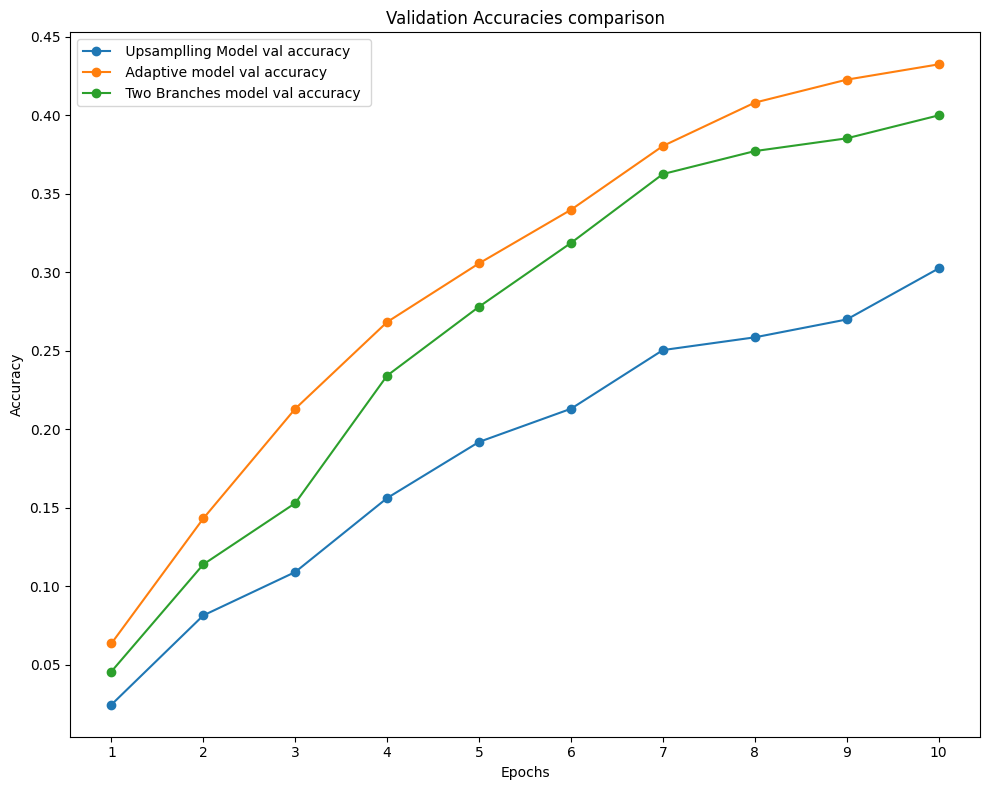

In [22]:
plt.figure(figsize=(10, 8))
# plt.plot(range(1, epochs + 1), val_accuracy, label=' model_0 val accuracy ', marker='o')
plt.plot(range(1, epochs + 1), val_accuracy_tr , label=' Upsamplling Model val accuracy ', marker='o')
plt.plot(range(1, epochs + 1), val_accuracy_ad, label=' Adaptive model val accuracy ', marker='o')
plt.plot(range(1, epochs + 1), val_accuracy_br, label=' Two Branches model val accuracy ', marker='o')
plt.title('Validation Accuracies comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(1, epochs + 1))
plt.legend()
plt.tight_layout()
plt.show()

## 10. Pretrained Model (3pts)
Let's use pretrained model instead of the custom model we defined. Use a pre-trained ResNet-34 to train the model.
Things to consider here is for example, up to which layers of the Resnet you are going to keep and what layers to drop. Upto which layers to freeze. Also need to adjust final classifier layers.

Assignment 10~12 should be based on the ResNet-34 pretrained model

In [ ]:
root_path = './PokemonData'
classes = sorted(os.listdir(root_path))
count=0
count_dict = {}
num_classes = len(classes)
print(f'Total number of pokemons: {num_classes}')

for pokemon in classes:
    dir_path = os.path.join(root_path,pokemon)
    count+=len(os.listdir(dir_path))
    count_dict[pokemon] = len(os.listdir(dir_path))
print(f'Total number of images: {count}')
sorted_list =  sorted(count_dict.items(), key=lambda item: item[1], reverse=True)
sorted_list


dataset_dir = root_path

transform_data = transforms.Compose([transforms.Resize((400, 400)),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.RandomRotation(15),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

Total number of pokemons: 150
Total number of images: 6837


In [ ]:
dataset = torchvision.datasets.ImageFolder(root=dataset_dir, transform = transform_data)
torch.manual_seed(100)
train_size = int(len(dataset)*0.80)
val_size = int(len(dataset)*0.20) 
train_ds, val_ds = random_split(dataset, [train_size, val_size])

trainloader = DataLoader(train_ds, batch_size = 32, shuffle=True, num_workers = 2)
testloader = DataLoader(val_ds, batch_size = 32, shuffle=False, num_workers = 2)

print(len(train_ds), len(val_ds))



5456 1364


In [ ]:
def train_mod(model, criterion, optimizer, scheduler, n_epochs = None):
    
    losses = []
    accuracies = []
    test_accuracies = []
    
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(trainloader, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()

        epoch_duration = time.time()-since
        epoch_loss = running_loss/len(trainloader)
        epoch_acc = 100/32*running_correct/len(trainloader)
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch+1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies

In [ ]:
def eval_model(model):
    correct = 0.0
    total = 0.0
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model_ft(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print('Accuracy on the test images: %d %%' % (
        test_acc))
    return test_acc

In [ ]:
model_ft = models.resnet34(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, num_classes) #No. of classes = 150
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

num_epochs = 10
model_ft, training_losses, training_accs, test_accs = train_mod(model_ft, criterion, optimizer, lrscheduler, n_epochs= num_epochs)


/home/dooseop/miniconda3/envs/nuscenes/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dooseop/miniconda3/envs/nuscenes/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, duration: 42 s, loss: 2.4590, acc: 48.3187
Accuracy on the test images: 83 %
Epoch 2, duration: 42 s, loss: 0.3959, acc: 90.7895
Accuracy on the test images: 89 %
Epoch 3, duration: 43 s, loss: 0.1620, acc: 96.6557
Accuracy on the test images: 91 %
Epoch 4, duration: 43 s, loss: 0.0837, acc: 98.2091
Accuracy on the test images: 95 %
Epoch 5, duration: 43 s, loss: 0.0541, acc: 98.7208
Accuracy on the test images: 94 %
Epoch 6, duration: 43 s, loss: 0.0391, acc: 98.9583
Accuracy on the test images: 96 %
Epoch 7, duration: 43 s, loss: 0.0296, acc: 99.2142
Accuracy on the test images: 96 %
Epoch 8, duration: 43 s, loss: 0.0257, acc: 99.2142
Accuracy on the test images: 96 %
Epoch 9, duration: 42 s, loss: 0.0225, acc: 99.3056
Accuracy on the test images: 96 %
Epoch 10, duration: 43 s, loss: 0.0224, acc: 99.3421
Accuracy on the test images: 95 %
Finished Training


The results of this model demonstrate that a pre-trained model, an appropriate optimizer, and a learning rate scheduler work well together to achieve high classification accuracy in a comparatively short training time.

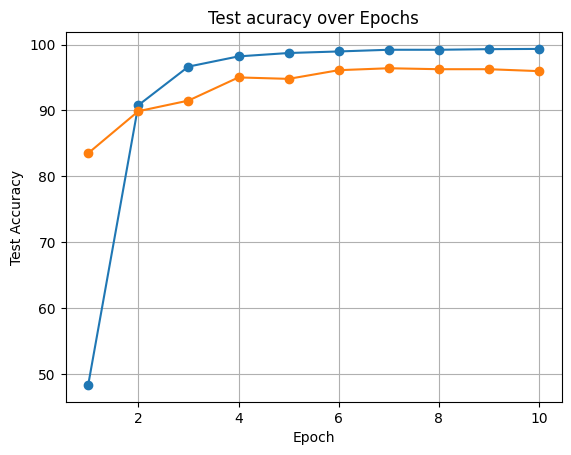

In [ ]:
# Visualize the validation accuracy
plt.plot(range(1, num_epochs+1), training_accs, marker='o')
plt.plot(range(1, num_epochs+1), test_accs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train (Blue) anf Test (Orange) accuracy over Epochs')
plt.grid(True)
plt.show()


## 11. Visualization by CAM (3pts)

Since this is Resnet, meaning that it has global average pooling. Let's make use of it and visualize using Class Activation Map (although we skipped this part in the class but you can easily understand it and there are lots of code that you can refer.)

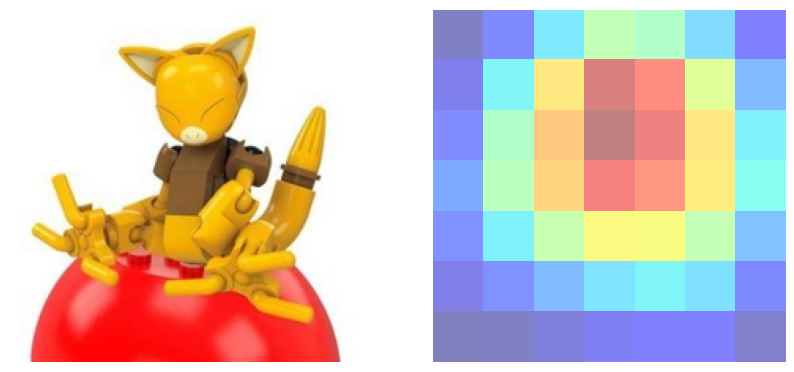

In [ ]:

features_blobs = []

def hook_feature(module, input, output):
    features_blobs.append(output)


model_ft.layer4[2].register_forward_hook(hook_feature)

# Function to generate the CAM
def generate_cam(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)
    cam = np.uint8(255 * cam)
    return cam

def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.to(device)

# Function to visualize CAM
def visualize_cam(model, img_path, class_idx):
    model.eval()
    img_tensor = preprocess_image(img_path)

    output = model(img_tensor)
    params = list(model.parameters())
    weight_softmax = params[-2].data.cpu().numpy()

    cam = generate_cam(features_blobs[0].cpu().data.numpy(), weight_softmax, class_idx)

    # Plot the image and the CAM
    img = Image.open(img_path)
    img = np.array(img.resize((224, 224)))
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()


img_path = './PokemonData/Abra/2fd28e699b7c4208acd1637fbad5df2d.jpeg'
class_idx = 0
visualize_cam(model_ft, img_path, class_idx)


CAM is a visualization tool used in CNN to highlight the portions of an input image that are important for the prediction and it is limited to visualizing the layer connected to the global average pooling. As we can see in the above image the model focuses on the main body of the Abra.

 

## 12 Visualization by GradCAM (3pts)

While CAM only allows us to visualize the layer connected to the global average pooling, GradCAM allows to visualize any layers. So try to visualize other layers as well by using GradCAM. You can do some search for the GradCAM code and use it.

/home/dooseop/miniconda3/envs/nuscenes/lib/python3.11/site-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


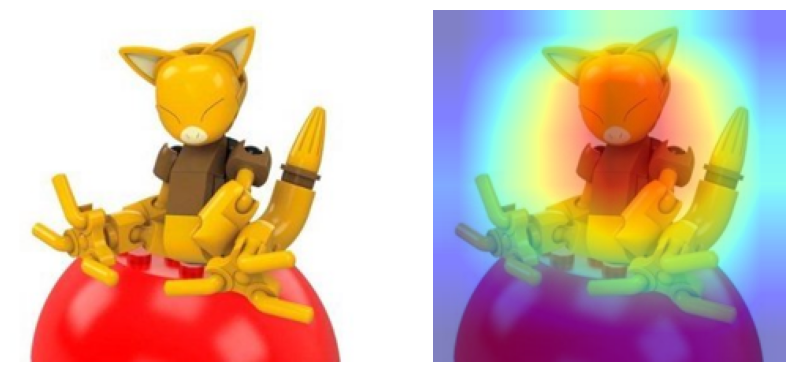

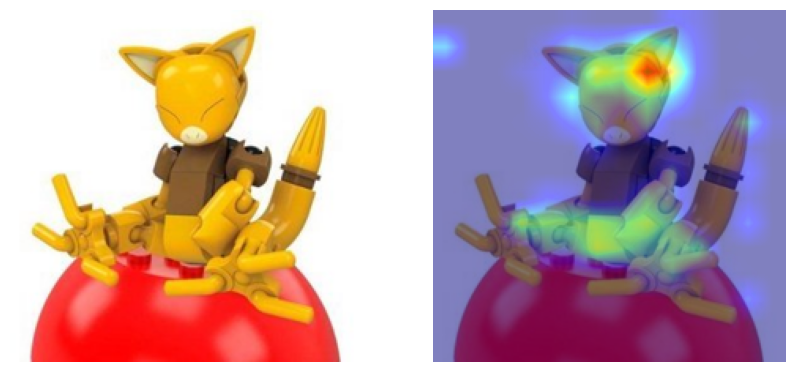

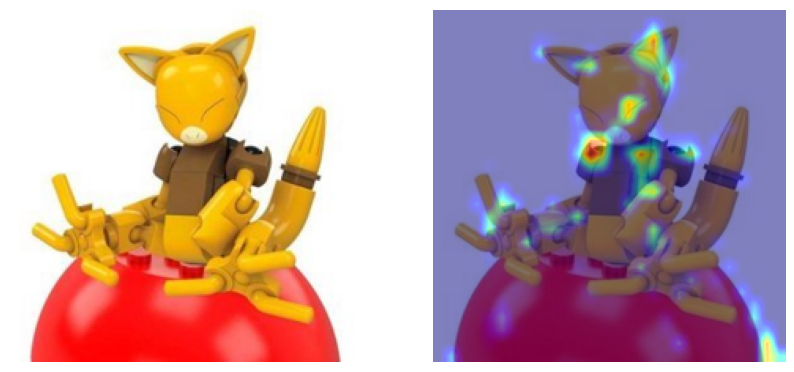

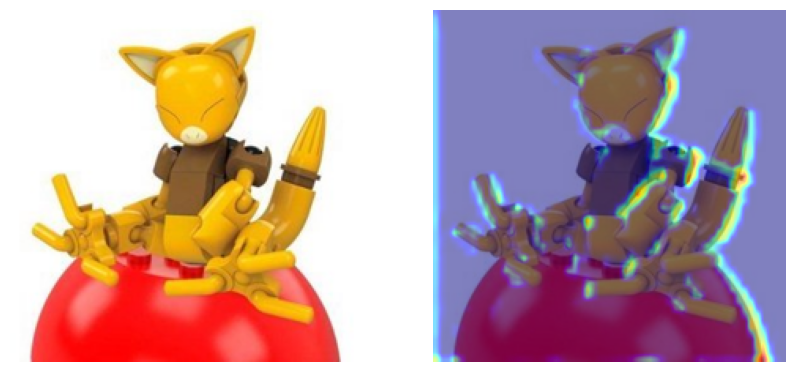

In [ ]:


class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handlers = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.hook_handlers.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handlers.append(self.target_layer.register_backward_hook(backward_hook))

    def generate_cam(self, input_image, class_idx=None):
        self.model.eval()
        output = self.model(input_image)

        if class_idx is None:
            class_idx = output.argmax().item()

        self.model.zero_grad()
        class_score = output[:, class_idx]
        class_score.backward()

        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        weights = np.mean(gradients, axis=(1, 2))
        cam = np.zeros(activations.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * activations[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, input_image.shape[2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        cam = np.uint8(255 * cam)

        return cam

    def __del__(self):
        for handle in self.hook_handlers:
            handle.remove()


def preprocess_image(img_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    img = Image.open(img_path)
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor.to(device)

# Function to visualize Grad-CAM
def visualize_gradcam(model, target_layer, img_path, class_idx=None):
    model.eval()
    img_tensor = preprocess_image(img_path)

    gradcam = GradCAM(model, target_layer)
    cam = gradcam.generate_cam(img_tensor, class_idx)

    img = Image.open(img_path)
    img = np.array(img.resize((224, 224)))
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img)
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(img)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.show()


img_path = './PokemonData/Abra/2fd28e699b7c4208acd1637fbad5df2d.jpeg'

# Visualize Grad-CAM for different layers
visualize_gradcam(model_ft, model_ft.layer4[2], img_path)
visualize_gradcam(model_ft, model_ft.layer3[5], img_path)
visualize_gradcam(model_ft, model_ft.layer2[3], img_path)
visualize_gradcam(model_ft, model_ft.layer1[2], img_path)


Grad_CAM can visualize any layer in the network, providing a detailed understanding of the model's behavior. As we can see in the above images, the Grad_CAM highlighted important portions of the Abra throughout the Network.


## 13. Bonus (3pts)

Do whatever in order to get, for example
- the highest accuracy
- Any ideas
- Whatever


We code the 13th assignments separately. We distributed data among trainning and Validation Datasets. After distribution, each Pokemon Category in the val dataset is now having 8 random images. We increases the batch size to 32 and number of ephocs is set to 100. 

In [ ]:

# def prep_val_data(pokemon, train_dir, val_dir):
#   pop = os.listdir(train_dir+'/'+pokemon)
#   val_data=random.sample(pop, 8)
#   print(val_data)
#   for f in val_data:
#     shutil.copy(train_dir+'/'+pokemon+'/'+f, val_dir+'/'+pokemon+'/')


# #performing samething for each folder in train folder
# for poke in os.listdir(train_dir):
#   prep_val_data(poke, train_dir, val_dir)

In [43]:

val_dir = "./models/input_data/val_data/"
train_dir = "./models/input_data/train_data/"
target_classes = os.listdir(train_dir)
num_classes = len(target_classes)
print('Number of target classes:', num_classes)
print(list(enumerate(target_classes)))

training_set_distribution = [len(os.listdir(os.path.join(train_dir, dir))) for dir in os.listdir(train_dir)]
val_set_distribution = [len(os.listdir(os.path.join(val_dir, dir))) for dir in os.listdir(val_dir)]

image_size = (64, 64)


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(image_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    'val': transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
}


train_dataset = ImageFolder(train_dir, data_transforms['train'])
val_dataset = ImageFolder(val_dir, data_transforms['val'])


batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


Number of target classes: 150
[(0, 'Golbat'), (1, 'Slowpoke'), (2, 'Bellsprout'), (3, 'Kakuna'), (4, 'Jigglypuff'), (5, 'Mew'), (6, 'MrMime'), (7, 'Seadra'), (8, 'Vileplume'), (9, 'Meowth'), (10, 'Magikarp'), (11, 'Nidoqueen'), (12, 'Weepinbell'), (13, 'Nidoking'), (14, 'Tentacool'), (15, 'Cloyster'), (16, 'Rhyhorn'), (17, 'Scyther'), (18, 'Jynx'), (19, 'Hitmonlee'), (20, 'Arcanine'), (21, 'Venonat'), (22, 'Shellder'), (23, 'Omastar'), (24, 'Vaporeon'), (25, 'Exeggutor'), (26, 'Sandshrew'), (27, 'Electabuzz'), (28, 'Magmar'), (29, 'Vulpix'), (30, 'Fearow'), (31, 'Tangela'), (32, 'Abra'), (33, 'Ditto'), (34, 'Moltres'), (35, 'Hitmonchan'), (36, 'Exeggcute'), (37, 'Starmie'), (38, 'Spearow'), (39, 'Sandslash'), (40, 'Ekans'), (41, 'Raticate'), (42, 'Lickitung'), (43, 'Gloom'), (44, 'Horsea'), (45, 'Koffing'), (46, 'Mewtwo'), (47, 'Charmeleon'), (48, 'Weedle'), (49, 'Growlithe'), (50, 'Butterfree'), (51, 'Nidorino'), (52, 'Magneton'), (53, 'Kingler'), (54, 'Staryu'), (55, 'Kabuto'), (56, 

In [44]:


class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.pool1(nn.functional.relu(self.conv1(x)))
        x = self.pool2(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = self.fc1(x)
        return x


model = CNN(num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
val_accuracies = []

num_epochs = 100
for epoch in range(num_epochs):
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch: {epoch+1}, Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}')

Epoch: 1, Validation Loss: 4.7118, Validation Accuracy: 0.0284
Epoch: 2, Validation Loss: 4.5176, Validation Accuracy: 0.0509
Epoch: 3, Validation Loss: 3.9382, Validation Accuracy: 0.1177
Epoch: 4, Validation Loss: 3.6094, Validation Accuracy: 0.1878
Epoch: 5, Validation Loss: 3.4945, Validation Accuracy: 0.1987
Epoch: 6, Validation Loss: 3.2636, Validation Accuracy: 0.2546
Epoch: 7, Validation Loss: 3.0971, Validation Accuracy: 0.2705
Epoch: 8, Validation Loss: 3.0032, Validation Accuracy: 0.2938
Epoch: 9, Validation Loss: 2.8625, Validation Accuracy: 0.3264
Epoch: 10, Validation Loss: 2.6518, Validation Accuracy: 0.3681
Epoch: 11, Validation Loss: 2.6242, Validation Accuracy: 0.3673
Epoch: 12, Validation Loss: 2.5384, Validation Accuracy: 0.3982
Epoch: 13, Validation Loss: 2.4331, Validation Accuracy: 0.3923
Epoch: 14, Validation Loss: 2.2697, Validation Accuracy: 0.4257
Epoch: 15, Validation Loss: 2.1596, Validation Accuracy: 0.4608
Epoch: 16, Validation Loss: 2.2027, Validation Ac

* We passed the input image through two convolutional layers with ReLU activations and max pooling to reduce its spatial dimensions while increasing its depth (number of channels).
* The output of the  conv and pooling layers is then flattened and passed through a fully connected layer, which corresponds to the number of classification classes.
* The final result is a vector of size num_classes that represents the logits for each class.
* The training results shows that the model improves the validation accuracy over time, indicating that the training process is effective.

* The final validation accuracy indicates that the model is quite effective at the classification task, but there is still a room for minor improvements to increase the accuracy further.


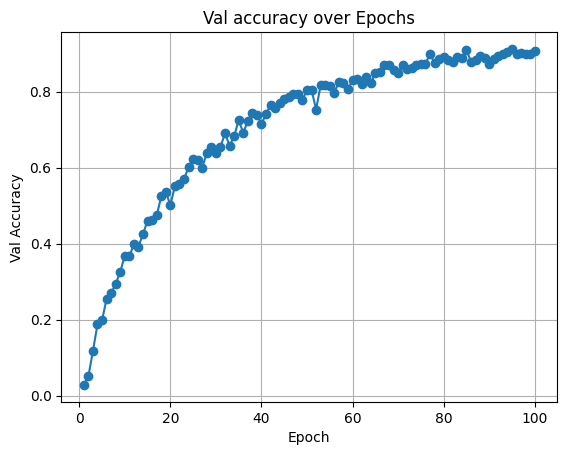

In [49]:
# Visualize the validation accuracy
plt.plot(range(1, num_epochs+1), val_accuracies, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')
plt.title('Val accuracy over Epochs')
plt.grid(True)
plt.show()
